In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

In [2]:

import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average ,Maximum
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
classes = os.listdir('/kaggle/input/paddy-plant-disease-dataset/train dataset12/test')
num_class=len(classes)
num_class

10

In [4]:
img=ImageDataGenerator(rescale=1./255)
#     ,rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, 
#     zoom_range=0.2,horizontal_flip=True, 
#     fill_mode="nearest")
# from tensorflow.keras.applications.resnet50 import preprocess_input
# img = ImageDataGenerator(preprocessing_function=preprocess_input)
SEED = 42
BATCH_SIZE = 64
EPOCHS = 250
LEARNING_RATE = 0.13
IMAGE_SIZE = 224

INIT_LR = 1e-3

In [5]:
train_ds = img.flow_from_directory('/kaggle/input/paddy-plant-disease-dataset/train dataset12/train',
                                       target_size=(640,480),
                                       shuffle=True, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       subset = 'training',
                                       batch_size=BATCH_SIZE,
                                       )

Found 7280 images belonging to 10 classes.


In [6]:
val_ds = img.flow_from_directory('/kaggle/input/paddy-plant-disease-dataset/train dataset12/val',
                                       target_size=(640,480),
                                       shuffle=True, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       
                                       batch_size=BATCH_SIZE,
                                       )

Found 1036 images belonging to 10 classes.


In [7]:
test_ds = img.flow_from_directory('/kaggle/input/paddy-plant-disease-dataset/train dataset12/test',
                                       target_size=(640,480),
                                       shuffle=False, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       )

Found 2091 images belonging to 10 classes.


In [8]:
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = 'SGD'

In [9]:
IncepResnet_model = tf.keras.models.load_model("/kaggle/input/inceptionresnetv2/InceptionResNetv2.h5",custom_objects={"custom_loss": loss}, compile=False)
IncepResnet_model = Model(inputs = IncepResnet_model.inputs, outputs = IncepResnet_model.outputs, name = 'IncepResnet_model')

inc_model = tf.keras.models.load_model("/kaggle/input/inception/Inception.h5",custom_objects={"custom_loss": loss}, compile=False)
inc_model = Model(inputs = inc_model.inputs, outputs = inc_model.outputs, name = 'inc_model')

xcept_model = tf.keras.models.load_model("/kaggle/input/xception/xCEPTIONV3_model.h5",custom_objects={"custom_loss": loss}, compile=False)
xcept_model = Model(inputs = xcept_model.inputs, outputs = xcept_model.outputs, name = 'xcept_model')

ResNet_model = tf.keras.models.load_model("/kaggle/input/resnet101/ResNet101.h5",custom_objects={"custom_loss": loss}, compile=False)
ResNet_model = Model(inputs = ResNet_model.inputs, outputs = ResNet_model.outputs, name = 'ResNet_model')

In [10]:
MobileNet_model = tf.keras.models.load_model("/kaggle/input/mobilenet-v2/mobilenetv2.h5",custom_objects={"custom_loss": loss}, compile=False)
MobileNet_model = Model(inputs = MobileNet_model.inputs, outputs = MobileNet_model.outputs, name = 'MobileNet_model')

DenseNet_model = tf.keras.models.load_model("/kaggle/input/densenet/densenet.h5",custom_objects={"custom_loss": loss}, compile=False)
DenseNet_model = Model(inputs = DenseNet_model.inputs, outputs = DenseNet_model.outputs, name = 'DenseNet_model')

In [12]:
models = [xcept_model , DenseNet_model,MobileNet_model]

model_input = Input(shape=(640,480,3))
model_outputs = [model(model_input) for model in models]

In [33]:
models = [ IncepResnet_model,MobileNet_model,DenseNet_model]

model_input = Input(shape=(640,480,3))
model_outputs = [model(model_input) for model in models]

In [13]:
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.compile(optimizer=optimizer, loss=loss, metrics = metrics)

In [ ]:
ensemble_output=Maximum()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.compile(optimizer=optimizer, loss=loss, metrics = metrics)

In [14]:
callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 3, restore_best_weights = True)

In [15]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 xcept_model (Functional)       (None, 10)           24370226    ['input_1[0][0]']                
                                                                                                  
 DenseNet_model (Functional)    (None, 10)           21683274    ['input_1[0][0]']                
                                                                                                  
 MobileNet_model (Functional)   (None, 10)           4881994     ['input_1[0][0]']         

In [16]:
history = ensemble_model.fit(
    train_ds,
    epochs = 25,
    validation_data = val_ds,callbacks = [callback2])

Epoch 1/25


2023-04-25 14:31:06.153501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/MobileNet_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


114/114 [==============================] - 321s 3s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1672 - val_accuracy: 0.9575
Epoch 2/25
114/114 [==============================] - 276s 2s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1676 - val_accuracy: 0.9575
Epoch 3/25
114/114 [==============================] - 276s 2s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1672 - val_accuracy: 0.9585
Epoch 4/25
114/114 [==============================] - 277s 2s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1676 - val_accuracy: 0.9595


In [ ]:
history = ensemble_model.fit(
    train_ds,
    epochs = 25,
    validation_data = val_ds,callbacks = [callback2])

In [17]:
ensemble_model.evaluate(test_ds)

33/33 [==============================] - 72s 2s/step - loss: 0.1960 - accuracy: 0.9531


[0.19596615433692932, 0.9531324505805969]

In [21]:
ensemble_model.save('ensemble2.h5')

ValueError: Unable to create dataset (name already exists)

metrics of ensemble model


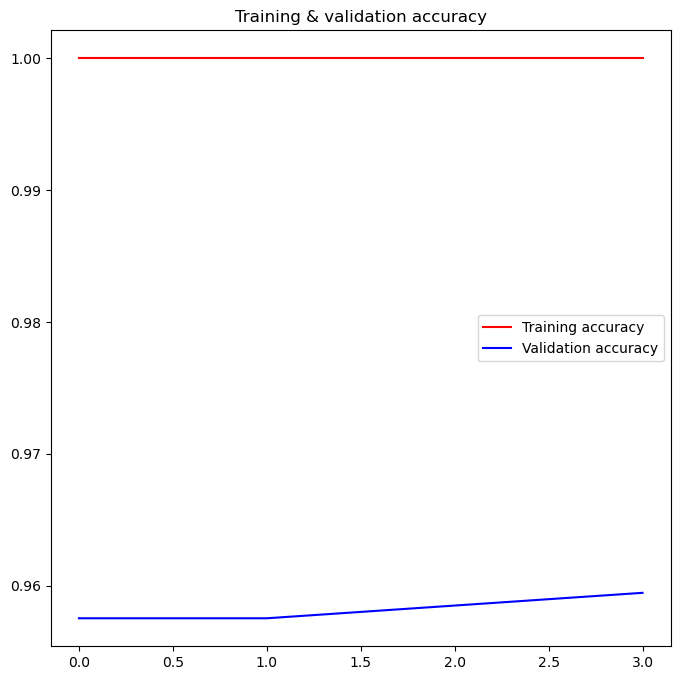

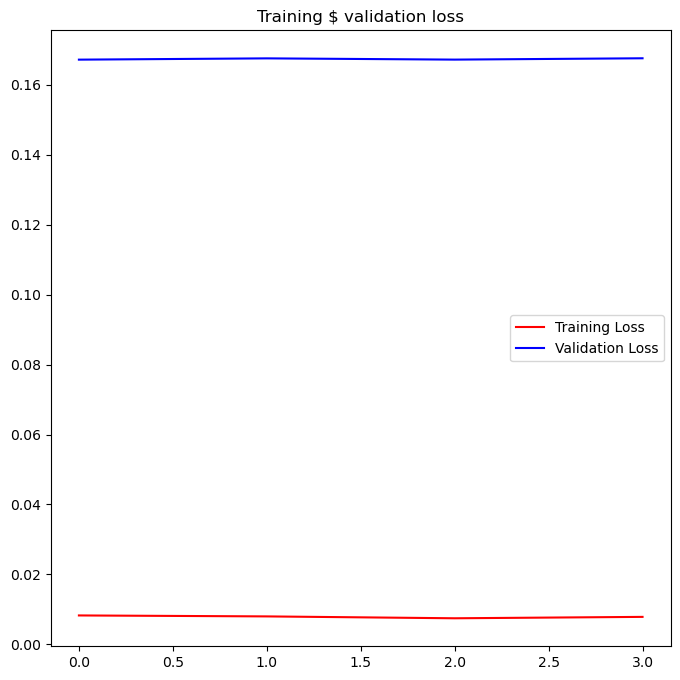

In [20]:
import matplotlib.pyplot as plt
print("metrics of ensemble model")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,8))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training & validation accuracy')
plt.legend()

plt.figure(figsize = (8,8))

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training $ validation loss')
plt.legend()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
test_steps_per_epoch = np.math.ceil(test_ds.samples / test_ds.batch_size)

predictions = ensemble_model.predict(test_ds, steps = test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report) 

33/33 [==============================] - 70s 2s/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.96      0.93      0.94        97
   bacterial_leaf_streak       1.00      0.97      0.99        76
bacterial_panicle_blight       0.95      0.88      0.92        69
                   blast       0.94      0.97      0.95       349
              brown_spot       0.98      0.93      0.95       194
              dead_heart       0.97      0.97      0.97       289
            downy_mildew       0.95      0.89      0.92       124
                   hispa       0.94      0.97      0.95       320
                  normal       0.97      0.96      0.96       354
                  tungro       0.92      0.95      0.94       219

                accuracy                           0.95      2091
               macro avg       0.96      0.94      0.95      2091
            weighted avg       0.95      0.95      0.95      2091



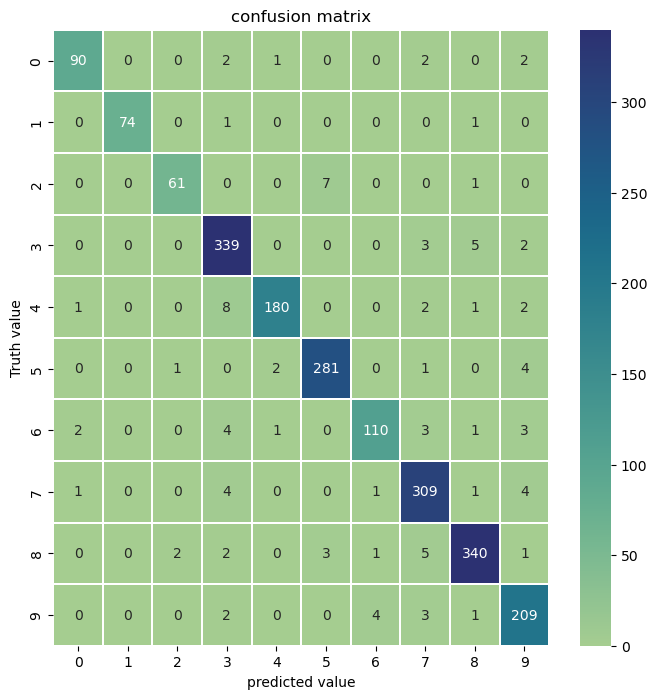

[[ 90   0   0   2   1   0   0   2   0   2]
 [  0  74   0   1   0   0   0   0   1   0]
 [  0   0  61   0   0   7   0   0   1   0]
 [  0   0   0 339   0   0   0   3   5   2]
 [  1   0   0   8 180   0   0   2   1   2]
 [  0   0   1   0   2 281   0   1   0   4]
 [  2   0   0   4   1   0 110   3   1   3]
 [  1   0   0   4   0   0   1 309   1   4]
 [  0   0   2   2   0   3   1   5 340   1]
 [  0   0   0   2   0   0   4   3   1 209]]


In [23]:
cm = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(true_classes, predicted_classes))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


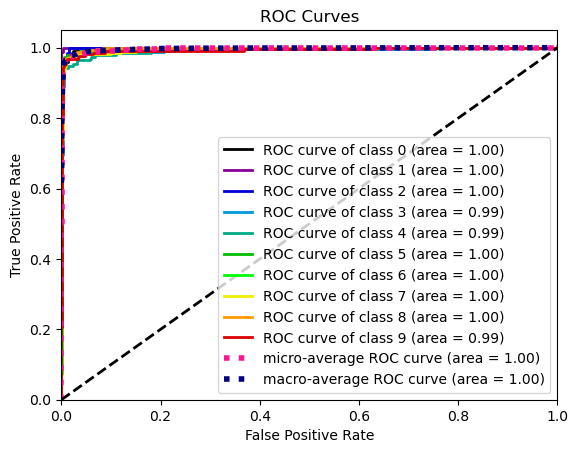

In [24]:

import scikitplot as skplt

y_true = true_classes
y_probas = predictions
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()